# Recipe Dataset EDA: datahiveai/recipes-with-nutrition

## Overview
This notebook performs a comprehensive Exploratory Data Analysis (EDA) on the `datahiveai/recipes-with-nutrition` dataset from HuggingFace.

**Goals:**
1. Understand the dataset structure and quality
2. Analyze nutritional data completeness and distribution
3. Explore recipe characteristics (cuisines, meal types, ingredients)
4. Identify data quality issues for ingestion
5. Prepare data cleaning strategy for ChromaDB ingestion

In [2]:
# 1. Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset

# Configure plotting
plt.style.use('ggplot')
sns.set_theme(style="whitegrid")
%matplotlib inline

/home/sardina/Documents/Portfolio/Foodify/backend/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


---

## 1️⃣ Import Libraries & Configuration

Set up the environment for analysis.

In [3]:
# 2. Load Dataset
print("Loading 'datahiveai/recipes-with-nutrition' dataset...")
dataset = load_dataset("datahiveai/recipes-with-nutrition", split="train")
df = dataset.to_pandas()
print(f"✓ Dataset loaded: {len(df):,} recipes\n")

# Basic info
print("=" * 60)
print("DATASET OVERVIEW")
print("=" * 60)
print(f"Shape: {df.shape}")
print(f"Memory Usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"\nColumns ({len(df.columns)}):")
for col in df.columns:
    print(f"  - {col} ({df[col].dtype})")

Loading 'datahiveai/recipes-with-nutrition' dataset...
✓ Dataset loaded: 39,447 recipes

DATASET OVERVIEW
Shape: (39447, 18)
Memory Usage: 402.35 MB

Columns (18):
  - recipe_name (object)
  - source (object)
  - url (object)
  - servings (float64)
  - calories (float64)
  - total_weight_g (float64)
  - image_url (object)
  - diet_labels (object)
  - health_labels (object)
  - cautions (object)
  - cuisine_type (object)
  - meal_type (object)
  - dish_type (object)
  - ingredient_lines (object)
  - ingredients (object)
  - total_nutrients (object)
  - daily_values (object)
  - digest (object)


---

## 2️⃣ Dataset Loading & Overview

Load the dataset from HuggingFace and inspect its basic structure.

In [4]:
# 3. Data Quality Assessment
print("=" * 60)
print("DATA QUALITY ANALYSIS")
print("=" * 60)

# Missing values analysis
missing = df.isnull().sum()
missing_pct = (missing / len(df) * 100).round(2)
quality_df = pd.DataFrame({
    'Missing Count': missing,
    'Missing %': missing_pct
}).sort_values('Missing %', ascending=False)

print("\nMissing Values Summary:")
print(quality_df[quality_df['Missing Count'] > 0])

# Check for duplicates
duplicates = df.duplicated(subset=['recipe_name']).sum()
print(f"\n✓ Duplicate recipe names: {duplicates:,}")

DATA QUALITY ANALYSIS

Missing Values Summary:
           Missing Count  Missing %
image_url            277        0.7

✓ Duplicate recipe names: 1,205


---

## 3️⃣ Data Quality Assessment

Identify missing values, duplicates, and overall data completeness.

NUTRITION DATA ANALYSIS

Available Nutrition Keys:
  K: {'unit': 'mg', 'label': 'Potassium', 'quantity': 1344.937282852889}
  P: {'unit': 'mg', 'label': 'Phosphorus', 'quantity': 378.2385}
  CA: {'unit': 'mg', 'label': 'Calcium', 'quantity': 316.2168927486673}
  FE: {'unit': 'mg', 'label': 'Iron', 'quantity': 4.986129792681675}
  MG: {'unit': 'mg', 'label': 'Magnesium', 'quantity': 93.09561258661114}
  ... (34 total keys)

NUTRITIONAL STATISTICS
       Calories  Protein (g)   Fat (g)  Carbs (g)  Fiber (g)  Sugar (g)
count  39447.00     39447.00  39446.00   39447.00   39447.00   39447.00
mean    2139.06        81.77    111.23     207.07      19.52      59.55
std     1924.70       100.75    135.02     231.38      23.37     136.01
min        0.06         0.00      0.00       0.00       0.00       0.00
25%      866.16        18.65     27.52      52.06       4.09       0.00
50%     1656.95        50.54     72.53     137.32      13.30      11.65
75%     2817.37       106.95    150.17     284

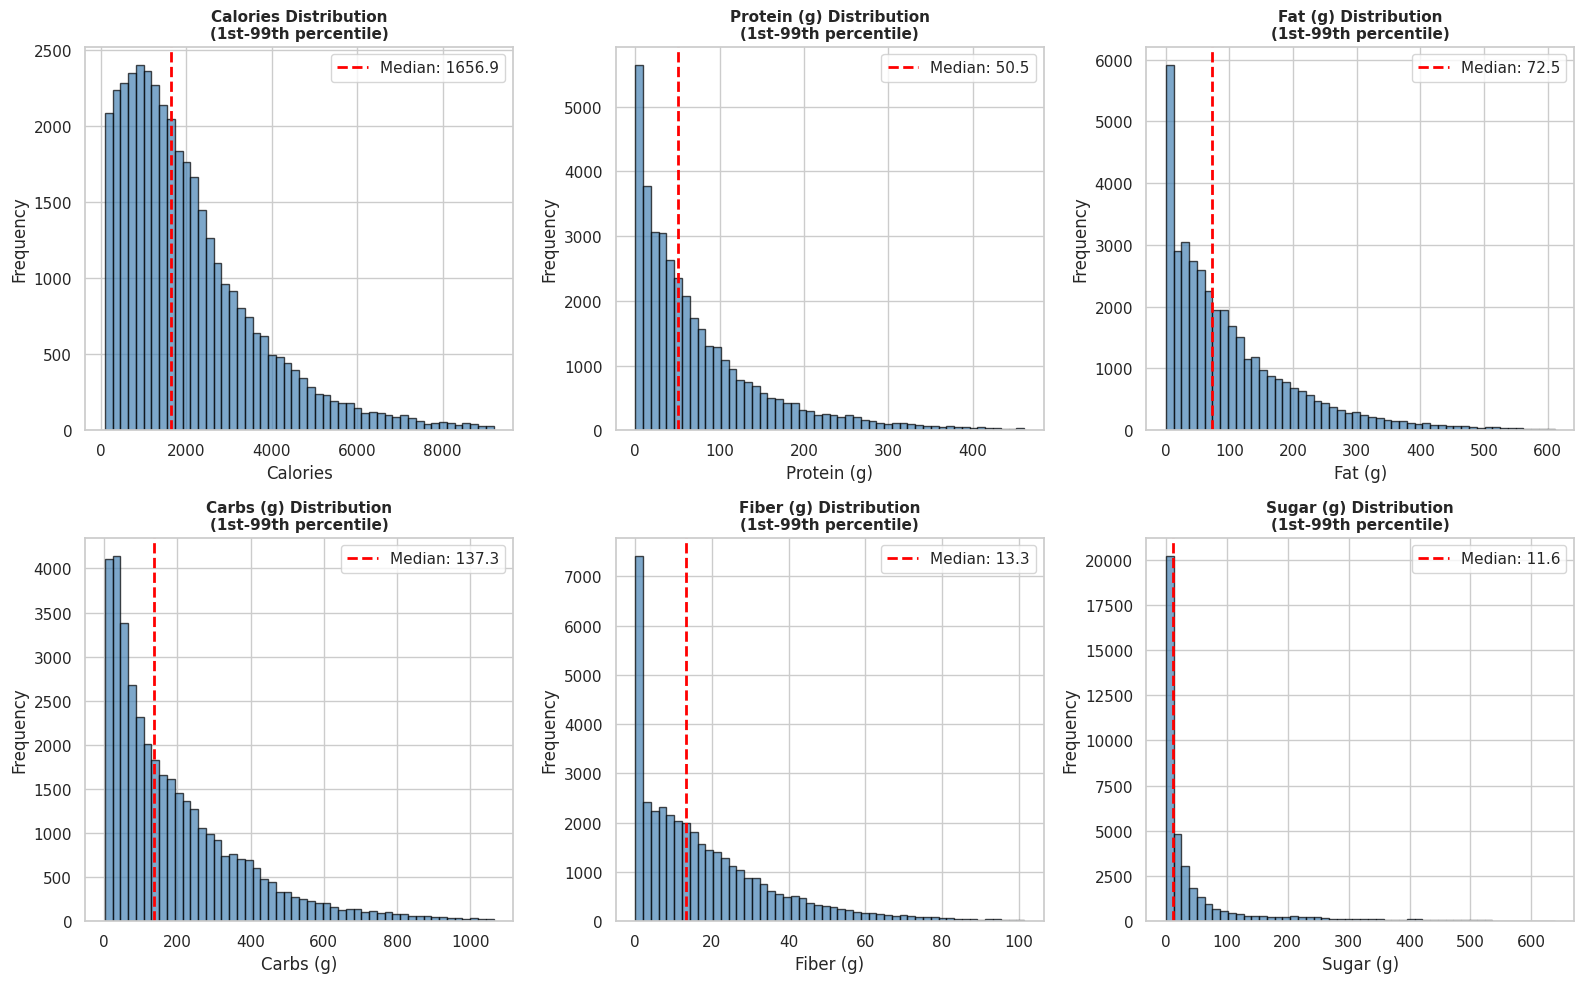


NUTRITION DATA COMPLETENESS
Calories            : 39,447 / 39,447 (100.0%)
Protein (g)         : 39,447 / 39,447 (100.0%)
Fat (g)             : 39,446 / 39,447 (100.0%)
Carbs (g)           : 39,447 / 39,447 (100.0%)
Fiber (g)           : 39,447 / 39,447 (100.0%)
Sugar (g)           : 39,447 / 39,447 (100.0%)


In [5]:
# 4. Nutrition Data Deep Dive
print("=" * 60)
print("NUTRITION DATA ANALYSIS")
print("=" * 60)

# Parse the total_nutrients column to understand its structure
if 'total_nutrients' in df.columns:
    sample_nutrition = df['total_nutrients'].dropna().iloc[0]
    if isinstance(sample_nutrition, str):
        import ast
        sample_nutrition = ast.literal_eval(sample_nutrition)
    
    print("\nAvailable Nutrition Keys:")
    if isinstance(sample_nutrition, dict):
        for key, value in list(sample_nutrition.items())[:5]:
            print(f"  {key}: {value}")
        print(f"  ... ({len(sample_nutrition)} total keys)")
    
    # Extract key nutrients
    nutrients_to_extract = {
        'ENERC_KCAL': 'Calories',
        'PROCNT': 'Protein (g)',
        'FAT': 'Fat (g)',
        'CHOCDF': 'Carbs (g)',
        'FIBTG': 'Fiber (g)',
        'SUGAR': 'Sugar (g)'
    }
    
    def safe_extract(row, key):
        if pd.isna(row): return None
        data = row
        if isinstance(data, str):
            try:
                import ast
                data = ast.literal_eval(data)
            except: return None
        if isinstance(data, dict) and key in data:
            item = data[key]
            if isinstance(item, dict) and 'quantity' in item:
                return item['quantity']
        return None
    
    for key, name in nutrients_to_extract.items():
        df[name] = df['total_nutrients'].apply(lambda x: safe_extract(x, key))
    
    # Statistical summary
    nutrient_cols = list(nutrients_to_extract.values())
    print("\n" + "=" * 60)
    print("NUTRITIONAL STATISTICS")
    print("=" * 60)
    print(df[nutrient_cols].describe().round(2))
    
    # Distribution plots
    fig, axes = plt.subplots(2, 3, figsize=(16, 10))
    axes = axes.flatten()
    
    for idx, col in enumerate(nutrient_cols):
        data = df[col].dropna()
        if len(data) > 0:
            # Remove extreme outliers for visualization
            q1, q99 = data.quantile([0.01, 0.99])
            filtered_data = data[(data >= q1) & (data <= q99)]
            
            axes[idx].hist(filtered_data, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
            axes[idx].set_title(f'{col} Distribution\n(1st-99th percentile)', fontsize=11, weight='bold')
            axes[idx].set_xlabel(col)
            axes[idx].set_ylabel('Frequency')
            axes[idx].axvline(data.median(), color='red', linestyle='--', linewidth=2, label=f'Median: {data.median():.1f}')
            axes[idx].legend()
    
    plt.tight_layout()
    plt.show()
    
    # Completeness check
    print("\n" + "=" * 60)
    print("NUTRITION DATA COMPLETENESS")
    print("=" * 60)
    for col in nutrient_cols:
        non_null = df[col].count()
        pct = (non_null / len(df) * 100)
        print(f"{col:20s}: {non_null:6,} / {len(df):,} ({pct:.1f}%)")
else:
    print("WARNING: 'total_nutrients' column not found!")

---

## 4️⃣ Nutrition Data Deep Dive

Extract and analyze key nutritional metrics from the `total_nutrients` column.

In [6]:
# 8. Data Quality Summary & Recommendations
print("=" * 60)
print("DATA QUALITY SUMMARY & RECOMMENDATIONS")
print("=" * 60)

# Essential columns check
essential_cols = ['Name', 'ingredient_lines', 'total_nutrients']
print("\n✓ ESSENTIAL COLUMNS CHECK:")
for col in essential_cols:
    if col in df.columns:
        missing = df[col].isnull().sum()
        pct = (missing / len(df) * 100)
        status = "✓ GOOD" if pct < 1 else "⚠ WARNING" if pct < 5 else "✗ CRITICAL"
        print(f"  {col:25s}: {status} ({pct:.2f}% missing)")
    else:
        print(f"  {col:25s}: ✗ MISSING COLUMN")

# Usability score
print("\n✓ DATASET USABILITY SCORE:")
usable_recipes = len(df.dropna(subset=[c for c in essential_cols if c in df.columns]))
usability_pct = (usable_recipes / len(df) * 100)
print(f"  Fully usable recipes: {usable_recipes:,} / {len(df):,} ({usability_pct:.1f}%)")

# Recommendations
print("\n" + "=" * 60)
print("RECOMMENDATIONS FOR INGESTION")
print("=" * 60)
print("""
1. COLUMN MAPPING:
   - 'Name' → Name
   - 'ingredient_lines' → RecipeIngredientParts
   - Extract from 'total_nutrients' → Calories, FatContent, etc.

2. DATA CLEANING:
   - Drop recipes with missing Name or ingredient_lines
   - Extract nutrition from 'total_nutrients' dict
   - Fill missing nutrition with -1.0 (sentinel value)
   - Default servings to 4 if missing

3. OPTIMIZATION:
   - Drop unused columns: 'source', 'url', 'image_url', etc.
   - Keep only app-required fields to reduce database size

4. QUALITY CHECKS:
   - Validate extracted nutrition values are numeric
   - Check for extreme outliers (Calories > 5000, etc.)
   - Ensure ingredient lists are non-empty
""")

DATA QUALITY SUMMARY & RECOMMENDATIONS

✓ ESSENTIAL COLUMNS CHECK:
  Name                     : ✗ MISSING COLUMN
  ingredient_lines         : ✓ GOOD (0.00% missing)
  total_nutrients          : ✓ GOOD (0.00% missing)

✓ DATASET USABILITY SCORE:
  Fully usable recipes: 39,447 / 39,447 (100.0%)

RECOMMENDATIONS FOR INGESTION

1. COLUMN MAPPING:
   - 'Name' → Name
   - 'ingredient_lines' → RecipeIngredientParts
   - Extract from 'total_nutrients' → Calories, FatContent, etc.

2. DATA CLEANING:
   - Drop recipes with missing Name or ingredient_lines
   - Extract nutrition from 'total_nutrients' dict
   - Fill missing nutrition with -1.0 (sentinel value)
   - Default servings to 4 if missing

3. OPTIMIZATION:
   - Drop unused columns: 'source', 'url', 'image_url', etc.
   - Keep only app-required fields to reduce database size

4. QUALITY CHECKS:
   - Validate extracted nutrition values are numeric
   - Check for extreme outliers (Calories > 5000, etc.)
   - Ensure ingredient lists are non-

---

## 5️⃣ Recipe Characteristics

Explore cuisine types, meal types, diet labels, and servings distribution.

NUTRITIONAL CORRELATIONS


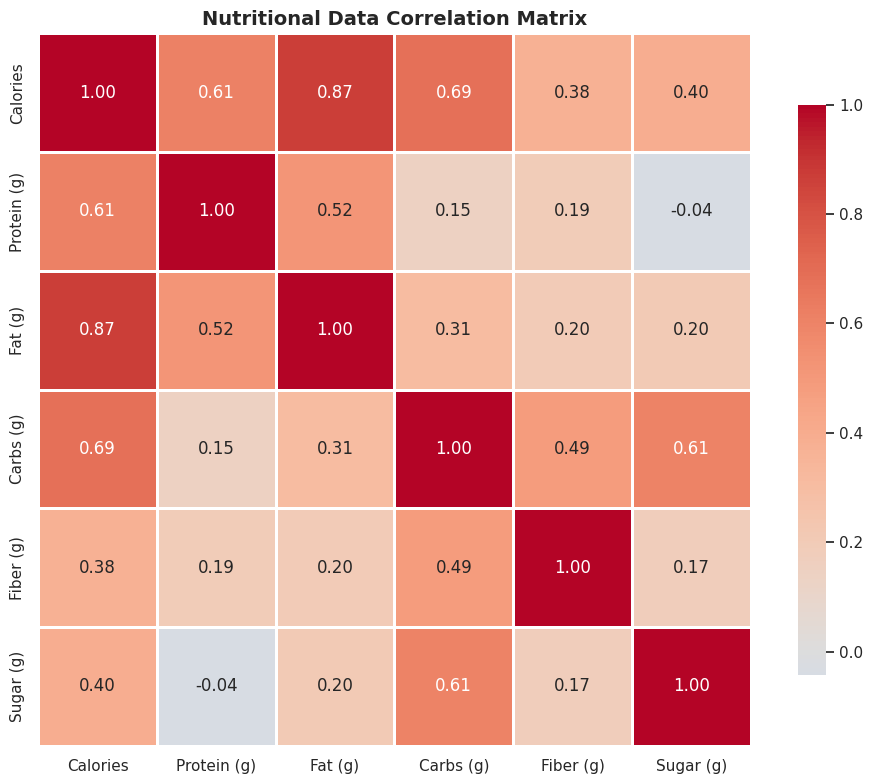

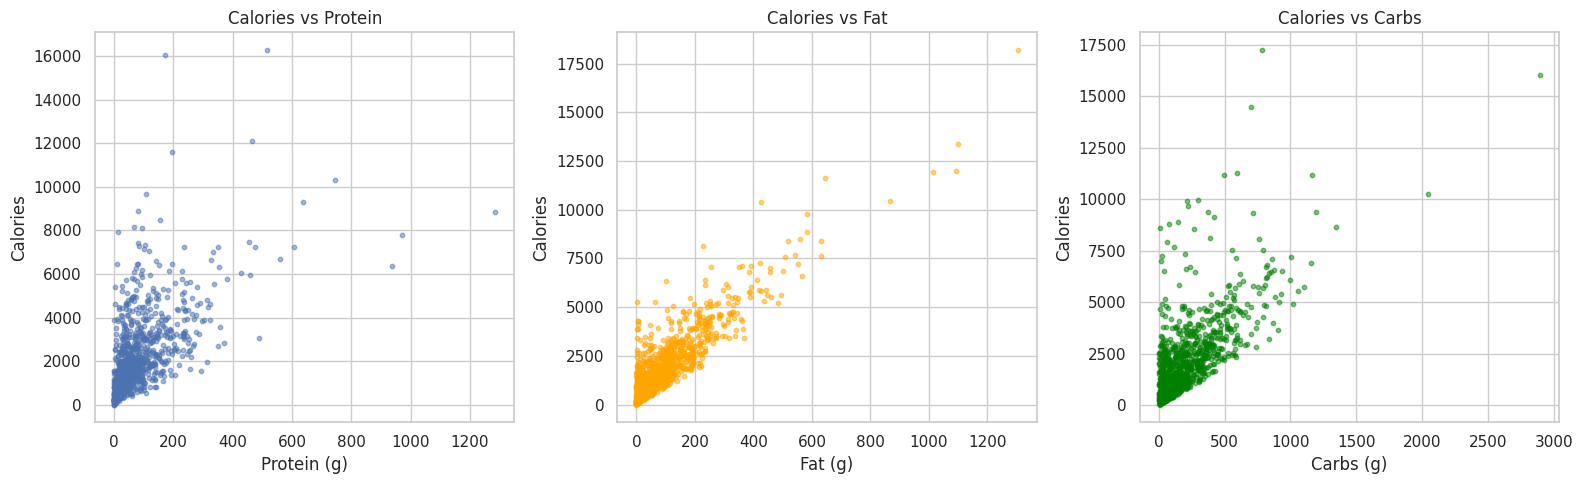

In [7]:
# 7. Correlation Analysis
print("=" * 60)
print("NUTRITIONAL CORRELATIONS")
print("=" * 60)

# Get numeric nutritional columns
nutrient_cols = ['Calories', 'Protein (g)', 'Fat (g)', 'Carbs (g)', 'Fiber (g)', 'Sugar (g)']
existing_nutrient_cols = [col for col in nutrient_cols if col in df.columns]

if len(existing_nutrient_cols) > 1:
    # Calculate correlation
    corr_matrix = df[existing_nutrient_cols].corr()
    
    # Visualize
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
                square=True, linewidths=1, cbar_kws={"shrink": 0.8})
    plt.title('Nutritional Data Correlation Matrix', fontsize=14, weight='bold')
    plt.tight_layout()
    plt.show()
    
    # Scatter plots for interesting correlations
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    
    # Calories vs Protein
    if 'Calories' in df.columns and 'Protein (g)' in df.columns:
        sample = df[['Calories', 'Protein (g)']].dropna().sample(min(1000, len(df)))
        axes[0].scatter(sample['Protein (g)'], sample['Calories'], alpha=0.5, s=10)
        axes[0].set_xlabel('Protein (g)')
        axes[0].set_ylabel('Calories')
        axes[0].set_title('Calories vs Protein')
    
    # Calories vs Fat
    if 'Calories' in df.columns and 'Fat (g)' in df.columns:
        sample = df[['Calories', 'Fat (g)']].dropna().sample(min(1000, len(df)))
        axes[1].scatter(sample['Fat (g)'], sample['Calories'], alpha=0.5, s=10, color='orange')
        axes[1].set_xlabel('Fat (g)')
        axes[1].set_ylabel('Calories')
        axes[1].set_title('Calories vs Fat')
    
    # Calories vs Carbs
    if 'Calories' in df.columns and 'Carbs (g)' in df.columns:
        sample = df[['Calories', 'Carbs (g)']].dropna().sample(min(1000, len(df)))
        axes[2].scatter(sample['Carbs (g)'], sample['Calories'], alpha=0.5, s=10, color='green')
        axes[2].set_xlabel('Carbs (g)')
        axes[2].set_ylabel('Calories')
        axes[2].set_title('Calories vs Carbs')
    
    plt.tight_layout()
    plt.show()

---

## 6️⃣ Ingredients Analysis

Analyze ingredient counts per recipe and identify the most common ingredients.

INGREDIENTS ANALYSIS

Ingredients per Recipe Statistics:
count    39447.000000
mean         8.799021
std          3.945063
min          2.000000
25%          6.000000
50%          8.000000
75%         11.000000
max         39.000000
Name: ingredient_count, dtype: float64


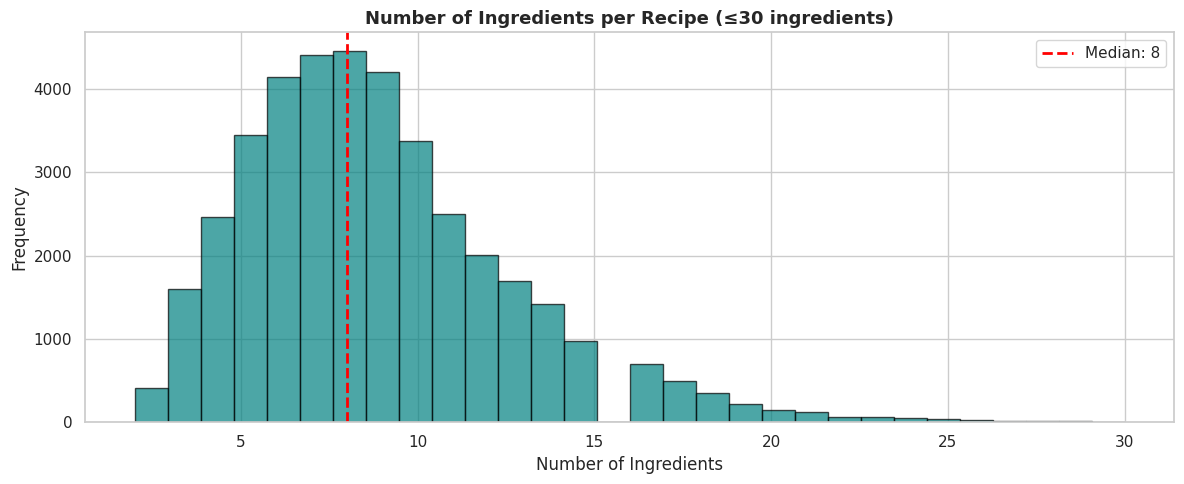


TOP 20 MOST COMMON INGREDIENTS
salt                                           1863
1 teaspoon salt                                1120
2 tablespoons olive oil                        1064
1/2 teaspoon salt                              1001
1 tablespoon olive oil                          998
kosher salt                                     972
pepper                                          909
1 egg                                           701
salt and pepper                                 701
2 eggs                                          698
1/4 teaspoon salt                               641
1 teaspoon vanilla extract                      611
salt and pepper to taste                        573
freshly ground black pepper                     570
kosher salt and freshly ground black pepper     503
2 large eggs                                    464
2 cloves garlic, minced                         458
1 cup water                                     447
1 large egg                     

/tmp/ipykernel_358480/1512047820.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=ingredient_freq.values, y=ingredient_freq.index, palette='viridis')


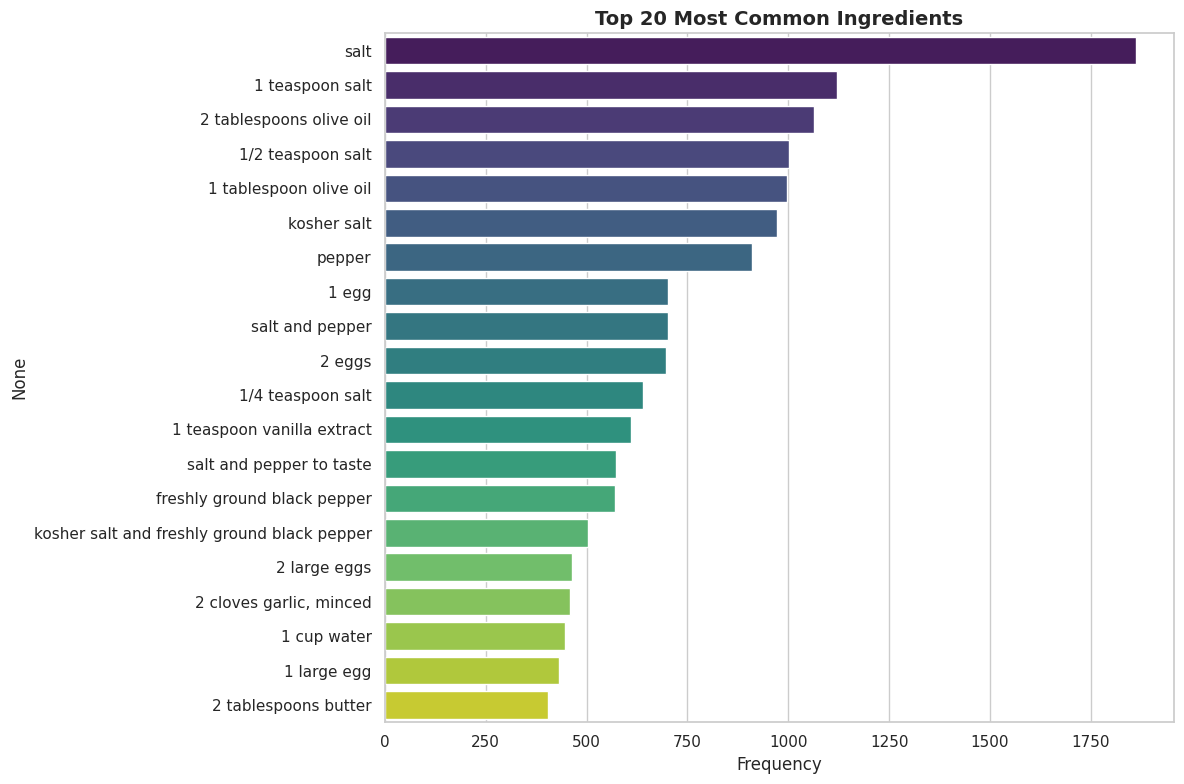

In [8]:
# 6. Ingredients Analysis
print("=" * 60)
print("INGREDIENTS ANALYSIS")
print("=" * 60)

if 'ingredient_lines' in df.columns:
    # Count ingredients per recipe
    df['ingredient_count'] = df['ingredient_lines'].apply(
        lambda x: len(eval(x)) if isinstance(x, str) and x.startswith('[') else (len(x) if isinstance(x, list) else 0)
    )
    
    print("\nIngredients per Recipe Statistics:")
    print(df['ingredient_count'].describe())
    
    # Visualize
    plt.figure(figsize=(12, 5))
    ingredient_counts = df['ingredient_count'][df['ingredient_count'] <= 30]
    plt.hist(ingredient_counts, bins=30, color='teal', edgecolor='black', alpha=0.7)
    plt.title('Number of Ingredients per Recipe (≤30 ingredients)', fontsize=13, weight='bold')
    plt.xlabel('Number of Ingredients')
    plt.ylabel('Frequency')
    plt.axvline(df['ingredient_count'].median(), color='red', linestyle='--', linewidth=2, label=f'Median: {df["ingredient_count"].median():.0f}')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Most common ingredients
    all_ingredients = []
    for ing_list in df['ingredient_lines'].dropna():
        if isinstance(ing_list, str):
            try:
                import ast
                ing_list = ast.literal_eval(ing_list)
            except: continue
        if isinstance(ing_list, list):
            all_ingredients.extend([ing.lower().strip() for ing in ing_list])
    
    if all_ingredients:
        print("\n" + "=" * 60)
        print("TOP 20 MOST COMMON INGREDIENTS")
        print("=" * 60)
        ingredient_freq = pd.Series(all_ingredients).value_counts().head(20)
        print(ingredient_freq)
        
        plt.figure(figsize=(12, 8))
        sns.barplot(x=ingredient_freq.values, y=ingredient_freq.index, palette='viridis')
        plt.title('Top 20 Most Common Ingredients', fontsize=14, weight='bold')
        plt.xlabel('Frequency')
        plt.tight_layout()
        plt.show()

---

## 7️⃣ Correlation Analysis

Examine relationships between nutritional metrics.

RECIPE CHARACTERISTICS

CUISINE TYPE:
american          16879
italian            4480
mediterranean      3785
french             3111
british            1667
mexican            1657
world              1310
south american     1195
indian              915
chinese             786
Name: count, dtype: int64


/tmp/ipykernel_358480/3055792313.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.values, y=value_counts.index, palette='magma')


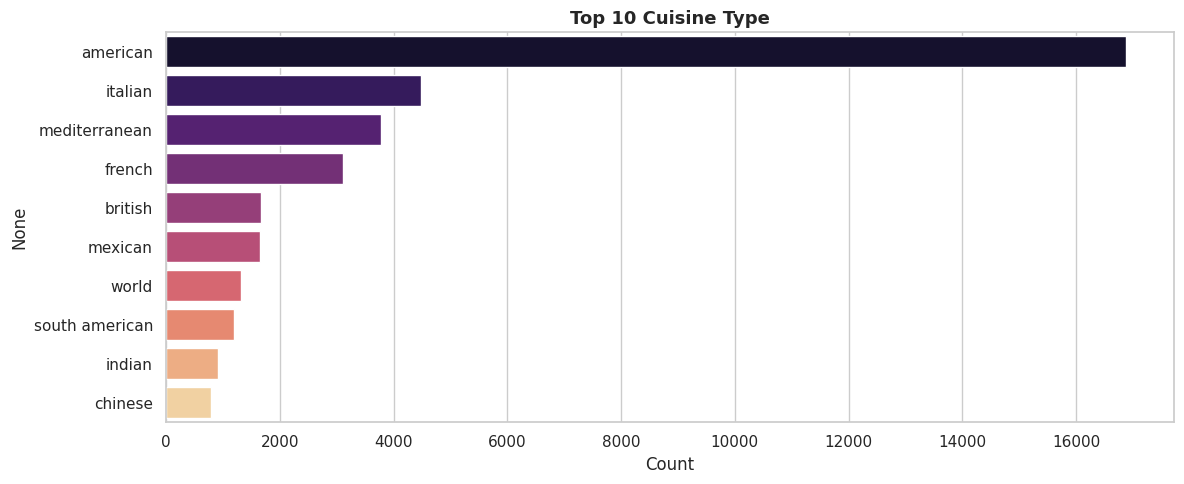


MEAL TYPE:
lunch/dinner    30143
snack            5595
breakfast        4290
brunch             23
teatime             1
Name: count, dtype: int64


/tmp/ipykernel_358480/3055792313.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.values, y=value_counts.index, palette='magma')


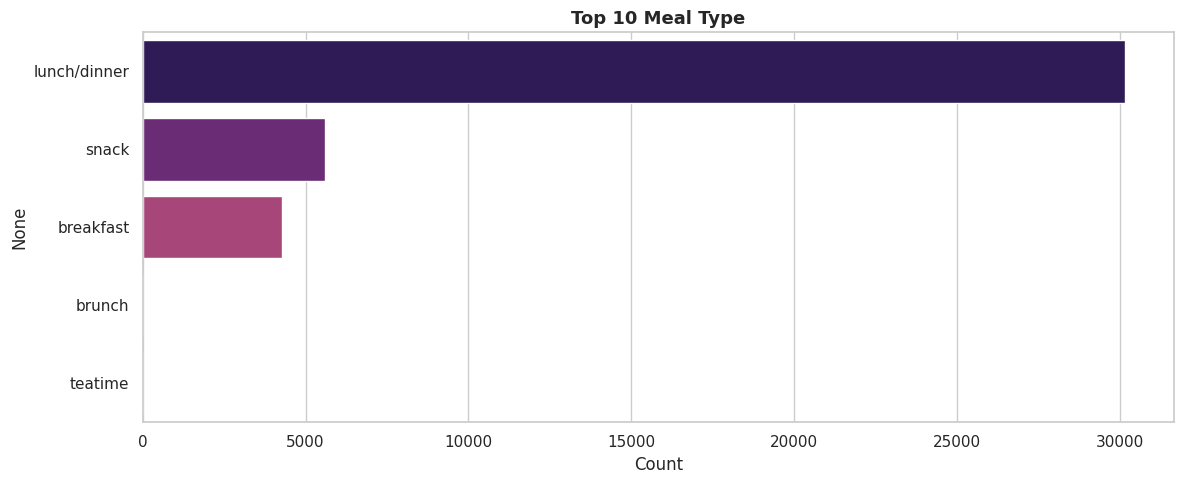


DISH TYPE:
main course              16480
desserts                  6309
salad                     3040
condiments and sauces     2757
starter                   2192
soup                      1650
biscuits and cookies      1550
drinks                    1545
bread                     1471
alcohol cocktail          1310
Name: count, dtype: int64


/tmp/ipykernel_358480/3055792313.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.values, y=value_counts.index, palette='magma')


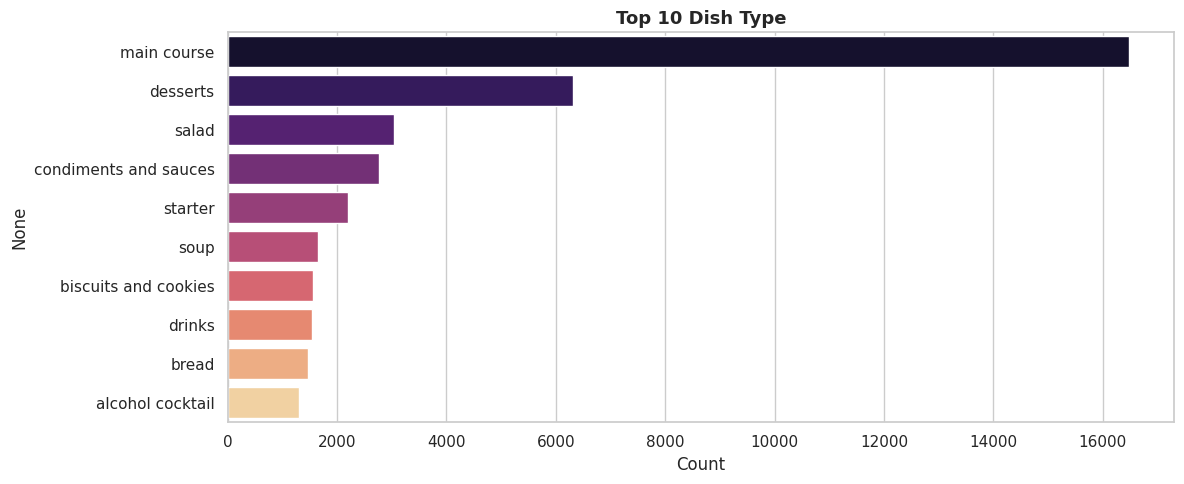


DIET LABELS:
Low-Sodium      12241
Low-Carb        11034
High-Fiber      10485
Low-Fat          6914
Balanced         5970
High-Protein     1100
Name: count, dtype: int64


/tmp/ipykernel_358480/3055792313.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.values, y=value_counts.index, palette='magma')


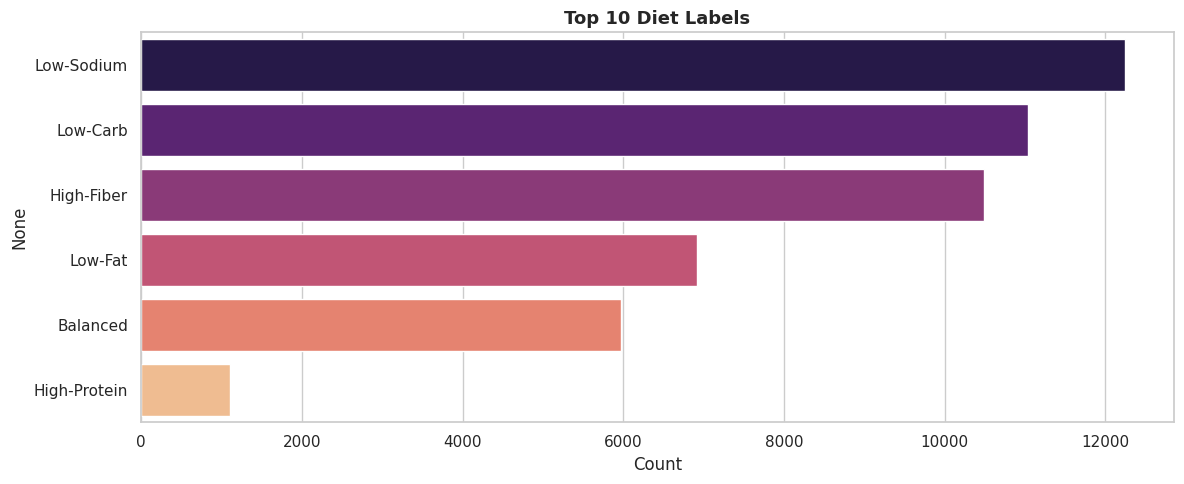


HEALTH LABELS:
Peanut-Free       37902
Shellfish-Free    37784
Fish-Free         36195
Soy-Free          35575
Tree-Nut-Free     33780
Egg-Free          29713
Vegetarian        24584
Gluten-Free       22348
Dairy-Free        19328
Vegan             10005
Name: count, dtype: int64


/tmp/ipykernel_358480/3055792313.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.values, y=value_counts.index, palette='magma')


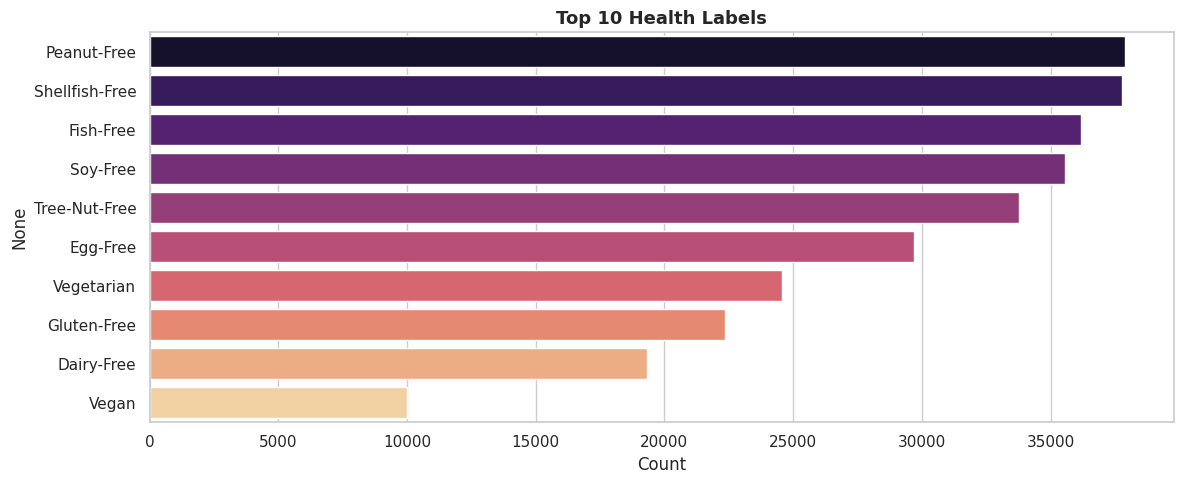


SERVINGS DISTRIBUTION
count    39447.000000
mean         7.564720
std         15.301538
min          1.000000
25%          4.000000
50%          6.000000
75%          8.000000
max       1520.000000
Name: servings, dtype: float64


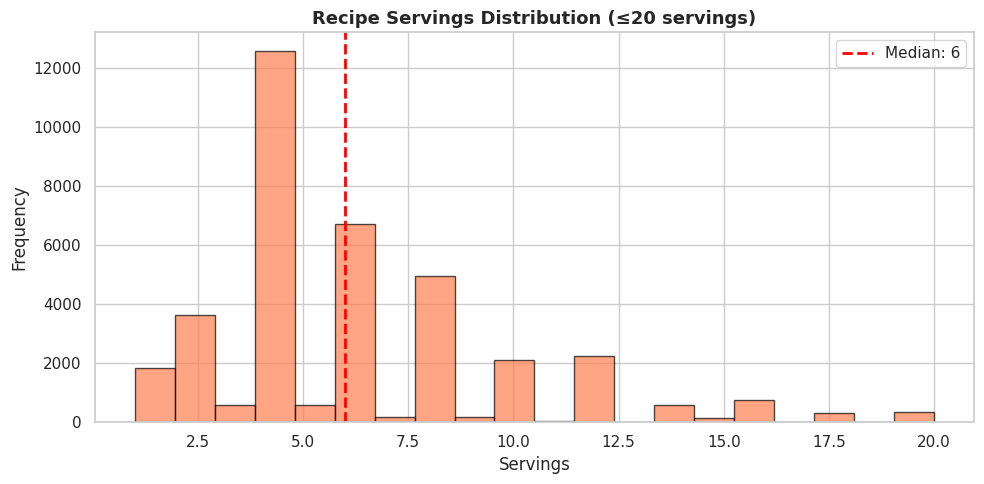

In [9]:
# 5. Recipe Characteristics Analysis
print("=" * 60)
print("RECIPE CHARACTERISTICS")
print("=" * 60)

# Analyze categorical features
categorical_features = ['cuisine_type', 'meal_type', 'dish_type', 'diet_labels', 'health_labels']

for feature in categorical_features:
    if feature in df.columns:
        print(f"\n{feature.upper().replace('_', ' ')}:")
        
        # Handle list-type columns
        if df[feature].dtype == 'object':
            # Flatten lists
            all_values = []
            for val in df[feature].dropna():
                if isinstance(val, str):
                    try:
                        import ast
                        val = ast.literal_eval(val)
                    except: pass
                if isinstance(val, list):
                    all_values.extend(val)
                elif isinstance(val, str):
                    all_values.append(val)
            
            if all_values:
                value_counts = pd.Series(all_values).value_counts().head(10)
                print(value_counts)
                
                # Visualize top categories
                if len(value_counts) > 0:
                    plt.figure(figsize=(12, 5))
                    sns.barplot(x=value_counts.values, y=value_counts.index, palette='magma')
                    plt.title(f'Top 10 {feature.replace("_", " ").title()}', fontsize=13, weight='bold')
                    plt.xlabel('Count')
                    plt.tight_layout()
                    plt.show()

# Servings analysis
if 'servings' in df.columns:
    print("\n" + "=" * 60)
    print("SERVINGS DISTRIBUTION")
    print("=" * 60)
    servings_data = pd.to_numeric(df['servings'], errors='coerce').dropna()
    print(servings_data.describe())
    
    plt.figure(figsize=(10, 5))
    servings_filtered = servings_data[servings_data <= 20]  # Filter outliers
    plt.hist(servings_filtered, bins=20, color='coral', edgecolor='black', alpha=0.7)
    plt.title('Recipe Servings Distribution (≤20 servings)', fontsize=13, weight='bold')
    plt.xlabel('Servings')
    plt.ylabel('Frequency')
    plt.axvline(servings_data.median(), color='red', linestyle='--', linewidth=2, label=f'Median: {servings_data.median():.0f}')
    plt.legend()
    plt.tight_layout()
    plt.show()

---

## 8️⃣ Summary & Recommendations

Final assessment of data quality and actionable recommendations for data ingestion.

In [10]:
# 8. Data Quality Summary & Recommendations
print("=" * 60)
print("DATA QUALITY SUMMARY & RECOMMENDATIONS")
print("=" * 60)

# Define essential columns for our app
essential_cols = {
    'Name': 'Recipe name',
    'ingredient_lines': 'Recipe ingredients',
    'total_nutrients': 'Nutritional data'
}

print("\n✓ ESSENTIAL COLUMNS CHECK:")
print("-" * 60)
for col, description in essential_cols.items():
    if col in df.columns:
        missing = df[col].isnull().sum()
        pct = (missing / len(df) * 100)
        if pct < 1:
            status = "✓ EXCELLENT"
            icon = "🟢"
        elif pct < 5:
            status = "⚠ WARNING"
            icon = "🟡"
        else:
            status = "✗ CRITICAL"
            icon = "🔴"
        print(f"  {icon} {col:25s}: {status}")
        print(f"     └─ {description}")
        print(f"     └─ Missing: {missing:,} ({pct:.2f}%)")
    else:
        print(f"  🔴 {col:25s}: ✗ COLUMN NOT FOUND")
        print(f"     └─ {description}")

# Calculate usability metrics
print("\n" + "=" * 60)
print("DATASET USABILITY METRICS")
print("=" * 60)

existing_essential = [c for c in essential_cols.keys() if c in df.columns]
usable_recipes = len(df.dropna(subset=existing_essential))
usability_pct = (usable_recipes / len(df) * 100)

print(f"\n  Total Recipes:        {len(df):>10,}")
print(f"  Fully Usable:         {usable_recipes:>10,}")
print(f"  Usability Rate:       {usability_pct:>10.1f}%")

# Check extracted nutrition columns
if 'Calories' in df.columns:
    nutrient_cols = ['Calories', 'Protein (g)', 'Fat (g)', 'Carbs (g)', 'Fiber (g)', 'Sugar (g)']
    existing_nutrients = [c for c in nutrient_cols if c in df.columns]
    
    print(f"\n  Nutrition Extracted:  {len(existing_nutrients):>10} metrics")
    for col in existing_nutrients:
        non_null = df[col].count()
        pct = (non_null / len(df) * 100)
        print(f"    • {col:20s}: {pct:>5.1f}% complete")

# Check ingredient data
if 'ingredient_count' in df.columns:
    avg_ingredients = df['ingredient_count'].mean()
    median_ingredients = df['ingredient_count'].median()
    print(f"\n  Avg Ingredients:      {avg_ingredients:>10.1f}")
    print(f"  Median Ingredients:   {median_ingredients:>10.0f}")

# RECOMMENDATIONS
print("\n" + "=" * 60)
print("🎯 RECOMMENDATIONS FOR CHROMADB INGESTION")
print("=" * 60)

print("""
1. COLUMN MAPPING STRATEGY:
   ✓ 'Name' → Name (recipe title)
   ✓ 'ingredient_lines' → RecipeIngredientParts
   ✓ Extract from 'total_nutrients' → Nutritional metadata
      • ENERC_KCAL → Calories
      • PROCNT → ProteinContent
      • FAT → FatContent
      • CHOCDF → CarbohydrateContent
      • FIBTG → FiberContent
      • SUGAR → SugarContent
      • FASAT → SaturatedFatContent
      • CHOLE → CholesterolContent
      • NA → SodiumContent

2. DATA CLEANING REQUIREMENTS:
   ✓ Drop recipes with missing 'Name' or 'ingredient_lines'
   ✓ Parse 'total_nutrients' JSON/dict to extract numeric values
   ✓ Handle missing nutrition: Fill with -1.0 (sentinel for "Unknown")
   ✓ Map 'servings' → RecipeServings (default: 4.0 if missing)
   ✓ Validate numeric ranges (e.g., Calories > 0, < 10000)

3. OPTIMIZATION TIPS:
   ✓ Drop unused columns to reduce memory:
      • 'source', 'url', 'image_url' (not needed for RAG)
      • 'digest', 'daily_values' (redundant with total_nutrients)
      • 'total_weight_g' (not used by app)
   
   ✓ Keep useful metadata:
      • 'cuisine_type', 'meal_type', 'dish_type'
      • 'diet_labels', 'health_labels', 'cautions'
      
4. EXPECTED INGESTION YIELD:
   ✓ Estimated Usable Recipes: """ + f"{usable_recipes:,}" + f""" ({usability_pct:.1f}%)
   ✓ Estimated Loss: """ + f"{len(df) - usable_recipes:,}" + f""" ({100-usability_pct:.1f}%)
   
5. DATA QUALITY SCORE:
""")

# Calculate overall quality score
quality_score = 0
max_score = 100

# Essential columns completeness (40 points)
if existing_essential:
    essential_completeness = df[existing_essential].notna().all(axis=1).sum() / len(df)
    quality_score += essential_completeness * 40

# Nutrition completeness (30 points)
if 'Calories' in df.columns:
    nutrition_completeness = df['Calories'].count() / len(df)
    quality_score += nutrition_completeness * 30

# Structural integrity (30 points)
if 'ingredient_lines' in df.columns:
    has_ingredients = df['ingredient_lines'].notna().sum() / len(df)
    quality_score += has_ingredients * 30

# Display score with visual indicator
if quality_score >= 90:
    grade = "A+"
    emoji = "🏆"
elif quality_score >= 80:
    grade = "A"
    emoji = "⭐"
elif quality_score >= 70:
    grade = "B"
    emoji = "✅"
elif quality_score >= 60:
    grade = "C"
    emoji = "⚠️"
else:
    grade = "D"
    emoji = "❌"

print(f"   {emoji} Overall Quality Score: {quality_score:.1f}/100 (Grade: {grade})")
print(f"   {'─' * 50}")
print(f"   Status: {'READY FOR INGESTION' if quality_score >= 70 else 'NEEDS IMPROVEMENT'}")

print("\n" + "=" * 60)
print("✅ EDA COMPLETE - Dataset ready for processing!")
print("=" * 60)

DATA QUALITY SUMMARY & RECOMMENDATIONS

✓ ESSENTIAL COLUMNS CHECK:
------------------------------------------------------------
  🔴 Name                     : ✗ COLUMN NOT FOUND
     └─ Recipe name
  🟢 ingredient_lines         : ✓ EXCELLENT
     └─ Recipe ingredients
     └─ Missing: 0 (0.00%)
  🟢 total_nutrients          : ✓ EXCELLENT
     └─ Nutritional data
     └─ Missing: 0 (0.00%)

DATASET USABILITY METRICS

  Total Recipes:            39,447
  Fully Usable:             39,447
  Usability Rate:            100.0%

  Nutrition Extracted:           6 metrics
    • Calories            : 100.0% complete
    • Protein (g)         : 100.0% complete
    • Fat (g)             : 100.0% complete
    • Carbs (g)           : 100.0% complete
    • Fiber (g)           : 100.0% complete
    • Sugar (g)           : 100.0% complete

  Avg Ingredients:             8.8
  Median Ingredients:            8

🎯 RECOMMENDATIONS FOR CHROMADB INGESTION

1. COLUMN MAPPING STRATEGY:
   ✓ 'Name' → Name (recipe